In [1]:
# Using only idx 2 and 3 GPUs
import os
from numba import cuda
gpu_count = len(cuda.gpus.lst)

# Only set the gpu indices if we are in the cluster
if gpu_count > 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

## Includes

In [2]:
import sys
import os
from PIL import Image, ImageDraw
import imageio
import torch
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import timm
from timm.models.vision_transformer import trunc_normal_

In [3]:
torch.cuda.is_available()

True

In [4]:
gpu_count = torch.cuda.device_count()
print(f"GPUs being used: {gpu_count}") 

GPUs being used: 2


## Model Implementation used as reference

In [5]:
class PatchEmbed(nn.Module):

    """
    Parameters:
        - img_size : int
        - patch_size : int
        - in_chans : int
        - embed_dim : int

    Internal Attributes:
        - n_patches : int
        - proj : nn.Conv2d
            Conv for splitting into patches and embedding
    """

    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        # NOTE(Abid): Conv2d is the hybrid architecture proposal of the paper,
        #             the original version has a MLP instead.
        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """
            Parameters:
                - x : torch.Tensor
                    Shape (batch, in_chans, img_size, img_size)

            Return: torch.Tensor
                    Shape (batch, n_patches, embed_dim)
        """
        x = self.proj(x) # Shape (batch, embed_dim, n_patches ** 0.5, n_patches ** 5)
        x = x.flatten(2) # Shape (batch, embed_dim, n_patches)
        x = x.transpose(1, 2) # Shape (batch, n_patches, embed_dim)

        return x

class MultiHeadAttention(nn.Module):
    """
        Parameters:
            - dim : int
                input and output dim of per token features
            - n_heads : int
            - qkv_bias : bool
            - attn_p : float
                Dropout probability for qkv
            - proj_p : float
                Dropout probability for output

        Attributes:
            - scale : float
                For scaled dot product
            - qkv : nn.Linear
            - proj : nn.Linear
            - attn_drop, proj_drop : nn.Dropout
    """

    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0, proj_p=0):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """
            Parameters:
                - x : torch.Tensor
                      Shape (batch, n_patches + 1, dim)

            Returns:
                - out : torch.Tensor
                        Shape (batch, n_patches + 1, dim)
        """
        batch, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x) # Shape : (batch, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(batch, n_tokens, 3, self.n_heads, self.head_dim) # Shape : (batch, n_patches+1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # Shape : (3, batch, n_heads, n_patches+1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1) # Shape : (batch, n_heads, head_dim, n_patches+1)
        dot = (q @ k_t) * self.scale # Shape : (batch, n_heads, n_patches+1, n_patches+1)
        attention = dot.softmax(dim=-1)
        attention = self.attn_drop(attention)

        weighted_avg = attention @ v # Shape : (batch, n_heads, n_patches+1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2) # Shape : (batch, n_patches+1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # Shape : (batch, n_patches+1, dim)

        x = self.proj(weighted_avg) # Shape : (batch, n_patches+1, dim)
        x = self.proj_drop(x)

        return x

class FeedForward(nn.Module):
    """
        Parameters:
            - in_features: int
            - hidden_features : int
            - out_features : int
            - p : float
                Dropout

        Attributes:
            - fc : nn.Linear
            - act : nn.GELU
                Activation
            - fc2 : nn.Linear
            - drop : nn.Dropout
    """

    def __init__(self, in_features, hidden_features, out_features, p=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """
            Parameters:
                - x : torch.Tensor
                      Shape (batch, n_patches +1, in_features)

            Returns:
                - torch.Tensor
                  Shape (batch, n_patches +1, out_features)
        """

        x = self.fc1(x) # Shape (batch, n_patches +1, hidden_features)
        x = self.act(x) 
        x = self.drop(x)
        x = self.fc2(x) # Shape (batch, n_patches +1, out_features)
        x = self.drop(x)

        return x


class Block(nn.Module):
    """
        Parameters:
            - dim : int
                Embedding
            - n_heads : int
            - mlp_ratio : float
                Determines the hidden dimension size of the MLP wrt dim
            - qkv_bias : bool
            - p, attn_p : float

        Attributes:
            - norm1, norm2 : LayerNorm
            - attention : Attention
            - mlp : MLP
    """

    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0.0, attn_p=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.mha = MultiHeadAttention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.ff = FeedForward(in_features=dim,
                              hidden_features=hidden_features,
                              out_features=dim)

    def forward(self, x):
        """
            Parameters
                - x : torch.Tensor
                      Shape (batch, n_patches + 1, dim)
            Returns
                - torch.Tensor
                  Shape (batch, n_patches + 1, dim)
        """

        x = x + self.mha(self.norm1(x))
        x = x + self.ff(self.norm2(x))

        return x

class VisionTransformer(nn.Module):
    """
        Parameters:
            - img_size : int
                Square image assumed
            - patch_size: int
            - in_chans : int
            - n_classes : int
            - embed_dim : int
            - depth : int
                Number of blocks
            - mlp_ratio : float
            - qkv_bias : bool
            - p, attn_p : float

        Attributes:
            - patch_embed : PatchEmbed
            - cls_token : nn.Parameter
                Prepended parameter used for classification, the first one in order
            - pos_emb : nn.Parameter
            - pos_drop : nn.Dropout
            - blocks: nn.ModuleList
            - norm : nn.LayerNorm
    """

    def __init__(self, img_size=384, patch_size=16, in_chans=3, n_classes=1000, embed_dim=768,
                 depth=12, n_heads=12, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_emb = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.Sequential(*[Block(dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio,
                                            qkv_bias=qkv_bias, p=p, attn_p=attn_p) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        # NOTE(Abid): According to the original paper, the MLP here should have a single hidden layer in training phase.
        self.pred_head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        """
            Parameters:
                - x : torch.Tensor
                      Shape (batch, in_chans, img_size, img_size)

            Returns:
                - logits : torch.Tensor
                           Shape (batch, n_classes)
        """

        batch = x.shape[0]
        x = self.patch_embed(x) # (batch, n_patches, embed_dim)
        cls_token = self.cls_token.expand(batch, -1, -1) # Shape (batch, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1) # Shape (batch, n_patches + 1, embed_dim)
        x = x + self.pos_emb
        x = self.pos_drop(x)
        x = self.blocks(x)
        x = self.norm(x)
        cls_token_final = x[:, 0] # Shape (batch, embed_dim) --> Only the first patch is used
        x = self.pred_head(cls_token_final) # (batch, n_classes)

        return x


In [6]:
class DeitTransformer(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_prefix_tokens = 2
        self.dist_token = nn.Parameter(torch.zeros(1, 1, kwargs.get('embed_dim')))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.n_patches + self.num_prefix_tokens, kwargs.get('embed_dim')))
        self.head_dist = nn.Linear(kwargs.get('embed_dim'), kwargs.get("n_classes")) if kwargs.get("n_classes") > 0 else nn.Identity()
        self.distilled_training = False
        
    def init_weights(self, mode=''):
        trunc_normal_(self.dist_token, std=.02)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = torch.cat((
            self.cls_token.expand(x.shape[0], -1, -1),
            self.dist_token.expand(x.shape[0], -1, -1), x),
            dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        
        x, x_dist = x[:, 0], x[:, 1]
        x = self.pred_head(x)
        x_dist = self.head_dist(x_dist)
        return (x + x_dist) / 2

In [ ]:
custom_config = {
    "n_classes" : 1000,
    "img_size" : 224,
    "patch_size" : 16,
    "in_chans" : 3,
    "embed_dim" : 192,
    "depth" : 12,
    "n_heads" : 3,
    "qkv_bias" : True,
    "mlp_ratio" : 4
}
deit_model = DeitTransformer(**custom_config)
deit_model.eval();

model_official = timm.create_model("deit_tiny_patch16_224", pretrained=True)

for (n_o, p_o), (n_c, p_c) in zip (model_official.named_parameters(),
                                   deit_model.named_parameters()):
    # assert p_o.numel() == p_c.numel()
    print(f"{n_o} | {n_c}")

    # p_c.data[:] = p_o.data

    # assert_tensors_equal(p_c.data, p_o.data)

In [10]:
model.blocks[0]

Block(
  (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=192, out_features=576, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=192, out_features=192, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=192, out_features=768, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=768, out_features=192, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [34]:
def assert_tensors_equal(t1, t2):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()

# --------| Verifying the Model |----------
inputs = torch.rand(1, 3, 224, 224)
res_c = deit_model(inputs)
res_o = model_official(inputs)

#assert get_n_params(model_custom) == get_n_params(model_official)
assert_tensors_equal(res_c, res_o)

# torch.save(model_custom, "vit_model.pth")


# ---------| Inference |----------
k = 10

imagenet_labels = dict(enumerate(open("classes.txt")))

img = (np.array(Image.open("elephant.jpg")) / 256)
inputs = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32) # Shape (1, in_chans, img_size, img_size)
logits = deit_model(inputs) # Shape (1, n_classes)
probs = torch.nn.functional.softmax(logits, dim=-1)

top_probs, top_ixs = probs[0].topk(k)

for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    cls = imagenet_labels[ix].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")


0: porcupine, hedgehog                           --- 0.0052
1: electric_fan, blower                          --- 0.0049
2: loudspeaker, speaker, speaker_unit, loudspeaker_system, speaker_system --- 0.0047
3: folding_chair                                 --- 0.0046
4: window_screen                                 --- 0.0043
5: joystick                                      --- 0.0042
6: steel_arch_bridge                             --- 0.0041
7: space_heater                                  --- 0.0040
8: binoculars, field_glasses, opera_glasses      --- 0.0037
9: mousetrap                                     --- 0.0037


<hr>

## Implementation for attention rollout and grad attention rollout
References given below

In [7]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        
        for attention in attentions: # Attention shape: (1, 3, 197, 197)
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0] # # shape: (1, 197, 197)
                # print(f"Shape before max is {attention.shape}, After: {attention.max(axis=1)}")
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Pick a proper head fusion mode"

            # Drop the lowest attentions, but
            # don't drop the class token
            # print(f"attention heads fused size : {attention_heads_fused.size(0)}")
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1) # Shape : (1, 197*197)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            # print(sum(1 if i == 0 else 0 for i in indices[0]))
            # print(indices.shape)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1) # Shape : (1, 197, 197)
            a = a[0]

            result = torch.matmul(a, result) # Shape: (1, 197, 197)
                                             # How much information do we get from the token j
                                             # in prev. layer (result) into the token i here (a)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 1:] # Shape : (196)
    
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy() # Shape : (14, 14)
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion), output

In [18]:
len(model.blocks)

12

Using cache found in /home/hashimi/.cache/torch/hub/facebookresearch_deit_main


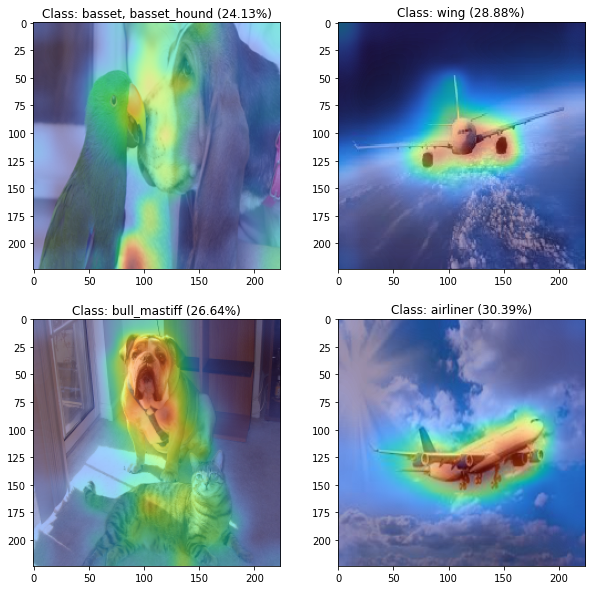

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

model = torch.hub.load('facebookresearch/deit:main',  'deit_tiny_patch16_224', pretrained=True).to(device)
model.eval()

gpu_reference_tensor = next(model.parameters())

classes = open("classes.txt").read().splitlines()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dir_path = './examples'
row = 0
col = 0
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, image_file in enumerate(os.listdir(dir_path)):
    if idx > 4:
        break
    if os.path.isfile(os.path.join(dir_path, image_file)):
        img = Image.open(os.path.join(dir_path, image_file))
        img = img.resize((224, 224))
        input_tensor = transform(img).unsqueeze(0)
        input_tensor = input_tensor.type_as(gpu_reference_tensor)

        category_index = None
        head_fusion = 'max'
        discard_ratio = 0.9
        attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
                discard_ratio=discard_ratio)
        mask, output = attention_rollout(input_tensor)
        
        probs = torch.nn.functional.softmax(output, dim=1)
        cat_idx = torch.argmax(probs).item()
        # print(cat_idx)
        
        np_img = np.array(img)
        heatmap = Image.fromarray(mask)
        heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
        ax[row, col].imshow(np_img)
        heatmap = (heatmap / np.max(heatmap)) * 255.0
        ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
                  alpha=0.5)
        ax[row, col].set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")
        
        if col == 1:
            row += 1
            col = 0
        else: col += 1
plt.show()

In [167]:
ten = torch.tensor([[1, 2, 3],
                    [3, 4, 5]], dtype=float)

In [84]:
ten.max(axis=1)

torch.return_types.max(
values=tensor([3., 5.], dtype=torch.float64),
indices=tensor([2, 2]))

In [22]:
def grad_rollout(attentions, gradients, discard_ratio):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask

In [29]:
class VITAttentionGradRollout:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        category_mask = torch.zeros(output.size()).to(device)
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()

        return grad_rollout(attentions=self.attentions,
                            gradients=self.attention_gradients,
                            discard_ratio=self.discard_ratio)

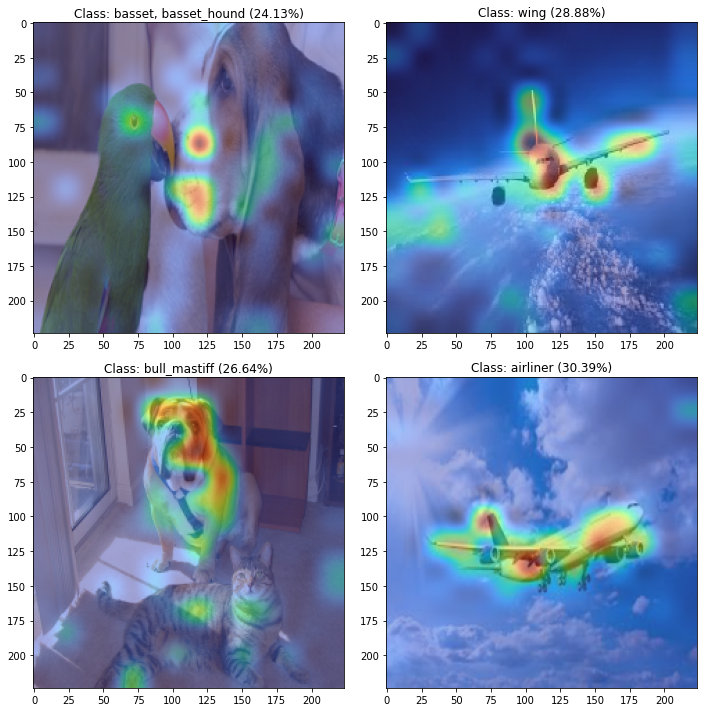

In [30]:
dir_path = './examples'
row = 0
col = 0
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, image_file in enumerate(os.listdir(dir_path)):
    if idx > 4:
        break
    if os.path.isfile(os.path.join(dir_path, image_file)):
        img = Image.open(os.path.join(dir_path, image_file))
        img = img.resize((224, 224))
        input_tensor = transform(img).unsqueeze(0).to(device)

        category_index = None
        head_fusion = 'max'
        discard_ratio = 0.9
        
        logits = model(input_tensor)
        category_index = torch.argmax(logits).item()
        probs = torch.nn.functional.softmax(logits, dim=1)
        prob = probs[0, category_index]
        
        grad_rollout_call = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout_call(input_tensor, category_index)
        
        np_img = np.array(img)
        heatmap = Image.fromarray(mask)
        heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
        ax[row, col].imshow(np_img)
        heatmap = (heatmap / np.max(heatmap)) * 255.0
        ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
                  alpha=0.5)
        ax[row, col].set_title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")
        if col == 1:
            row += 1
            col = 0
        else: col += 1
plt.tight_layout()
plt.show()

In [ ]:
img_path = './examples/input.png'
nrow = 5
ncol = 20

img = Image.open(img_path)
img = img.resize((224, 224))
x_stride = 50
y_stride = 50
occu_size = 50
growth_coef = 15

occlusion = np.zeros((occu_size, occu_size, 3))
np_img = np.array(img)

fig, ax = plt.subplots(nrow, ncol, figsize=(70, 20))

for row in range(nrow):
    x_pos = 0
    y_pos = 0
    x_end = occu_size
    y_end = occu_size
    
    for col in range(ncol):
        tmp_img = np.copy(np_img)
        tmp_img[y_pos:y_end, x_pos:x_end, :] = 0

        # NOTE(Abid): Model output and introspection
        input_tensor = transform(Image.fromarray(tmp_img)).unsqueeze(0).to(device)
        discard_ratio = 0.9
        logits = model(input_tensor)
        category_index = torch.argmax(logits).item()
        probs = torch.nn.functional.softmax(logits)
        prob = probs[0, category_index]
      
        grad_rollout_call = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout_call(input_tensor, category_index)
        
        heatmap = Image.fromarray(mask)
        heatmap = np.array(heatmap.resize((tmp_img.shape[0], tmp_img.shape[1])))
        ax[row, col].imshow(tmp_img)
        heatmap = (heatmap / np.max(heatmap)) * 255.0
        ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
                  alpha=0.5)
        ax[row, col].set_title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")
        
        # NOTE(Abid): Stride logic
        x_pos += x_stride
        x_end = x_pos+occu_size
        if x_pos > tmp_img.shape[0]:
            x_pos = 0
            x_end = x_pos+occu_size
            y_pos += y_stride
            y_end = y_pos+occu_size
        
        elif x_end > tmp_img.shape[0]:
            x_end = tmp_img.shape[0]
            
        if y_pos > tmp_img.shape[1]:
            break
        elif y_end > tmp_img.shape[1]:
            y_end = tmp_img.shape[1]
    occu_size += growth_coef
    
plt.tight_layout()
plt.show()
fig.savefig('occlusion.png')

/tmp/ipykernel_1943664/1351332836.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


243


C:\Users\Khisrow\AppData\Local\Temp\ipykernel_74580\3157749127.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(output)


Text(0.5, 1.0, 'Class: bull_mastiff (26.64%)')

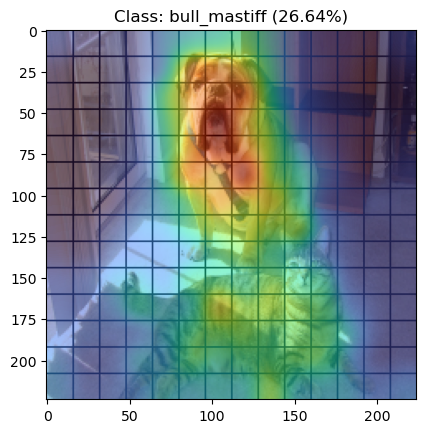

In [12]:
img_path = './examples/input.png'
img = Image.open(img_path)
img = img.resize((224, 224))
patch_size = 16

input_tensor = transform(img).unsqueeze(0)
steps = int(224/patch_size)

if use_cuda:
    input_tensor = input_tensor.cuda()

category_index = None
head_fusion = 'max'
discard_ratio = 0.9
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
        discard_ratio=discard_ratio)
mask, output = attention_rollout(input_tensor)

probs = torch.nn.functional.softmax(output)
cat_idx = torch.argmax(probs).item()
print(cat_idx)

np_img = np.array(img)
for x in range(steps-1):
    pos = (x+1)*patch_size
    np_img[:, pos:pos+1, :] = 0
    np_img[pos:pos+1, :, :] = 0

fig, ax = plt.subplots()
heatmap = Image.fromarray(mask)
heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
ax.imshow(np_img)
heatmap = (heatmap / np.max(heatmap)) * 255.0
ax.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
          alpha=0.5)
ax.set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")

C:\Users\Khisrow\AppData\Local\Temp\ipykernel_67180\626037042.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


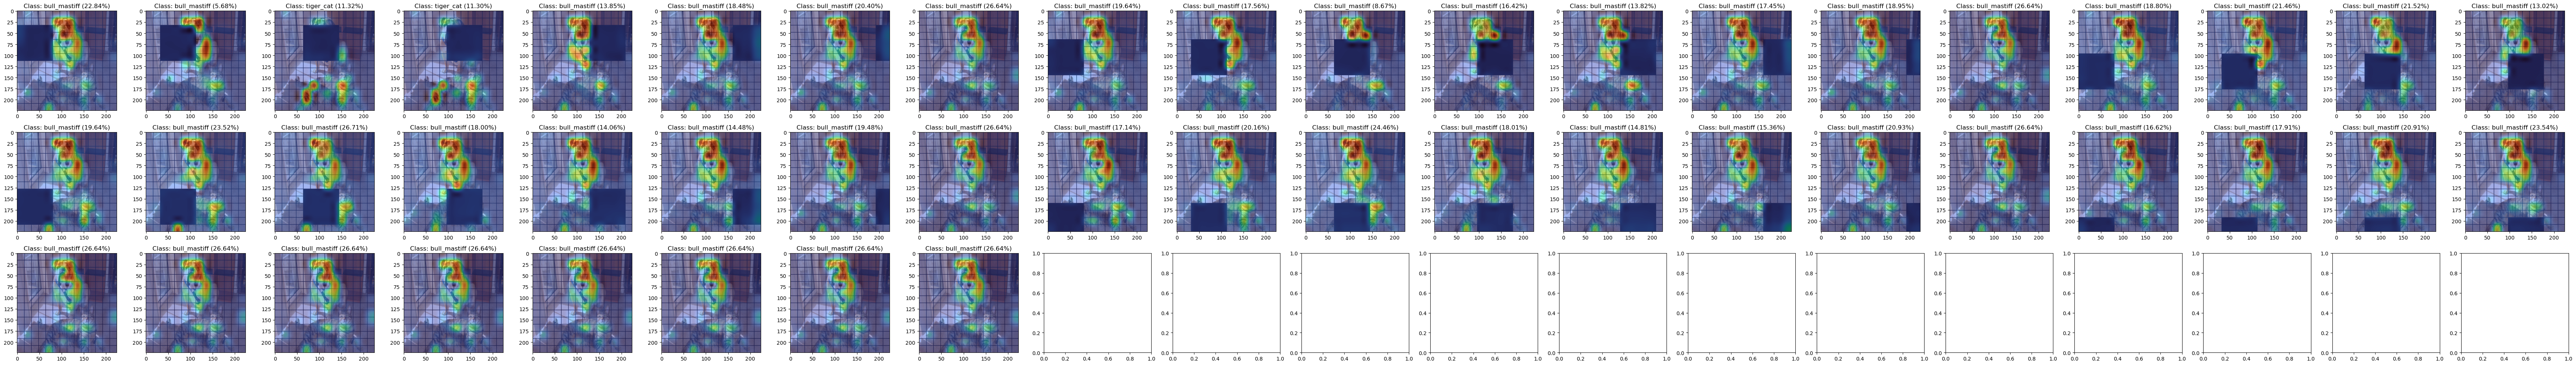

In [20]:
img_path = './examples/input.png'
nrow = 3
ncol = 20

img = Image.open(img_path)
img = img.resize((224, 224))
x_stride = 16*2
y_stride = 16*2
occu_size = 16*5

np_img = np.array(img)


fig, ax = plt.subplots(nrow, ncol, figsize=(70, 10))
finish = False
y_pos = 0
for row in range(nrow):
    x_pos = 0
    x_end = occu_size
    y_pos += y_stride
    y_end = y_pos+occu_size
    for col in range(ncol):
        tmp_img = np.copy(np_img)
        tmp_img[y_pos:y_end, x_pos:x_end, :] = 0

        # NOTE(Abid): Model output and introspection
        input_tensor = transform(Image.fromarray(tmp_img)).unsqueeze(0)
        discard_ratio = 0.9
        logits = model(input_tensor)
        category_index = torch.argmax(logits).item()
        probs = torch.nn.functional.softmax(logits)
        prob = probs[0, category_index]
      
        grad_rollout_call = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout_call(input_tensor, category_index)
        
        for x in range(steps-1):
            pos = (x+1)*patch_size
            tmp_img[:, pos:pos+1, :] = 0
            tmp_img[pos:pos+1, :, :] = 0
            
        heatmap = Image.fromarray(mask)
        heatmap = np.array(heatmap.resize((tmp_img.shape[0], tmp_img.shape[1])))
        ax[row, col].imshow(tmp_img)
        heatmap = (heatmap / np.max(heatmap)) * 255.0
        ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
                  alpha=0.5)
        ax[row, col].set_title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")
        
        # NOTE(Abid): Stride logic
        x_pos += x_stride
        x_end = x_pos+occu_size
        if x_pos > tmp_img.shape[0]:
            x_pos = 0
            x_end = x_pos+occu_size
            y_pos += y_stride
            y_end = y_pos+occu_size
        
        elif x_end > tmp_img.shape[0]:
            x_end = tmp_img.shape[0]
            
        if y_pos > tmp_img.shape[1]:
            finish = True
            break
        elif y_end > tmp_img.shape[1]:
            y_end = tmp_img.shape[1]
    # occu_size += 16
    if finish == True: break
    
plt.tight_layout()
plt.show()
fig.savefig('occlusion_patch_grid5x.png')

### Sources
- Exploring Explainability for Vision Transformers: https://jacobgil.github.io/deeplearning/vision-transformer-explainability
- Quantifying Attention Flow in Transformers: https://arxiv.org/abs/2005.00928
- Training data-efficient image transformers & distillation through attention: https://arxiv.org/abs/2012.12877
- An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale: https://arxiv.org/abs/2010.11929
- DeiT III: Revenge of the ViT: https://arxiv.org/pdf/2204.07118.pdf

### Stuff to look into:
- Transformer Interpretability Beyond Attention Visualization: https://arxiv.org/pdf/2012.09838v1.pdf

### Things to consider:
- The transformer patches the images and its prudent to see if the attentions align with the patches
- If the patches are important, move the image in such a way that the most important elements are cut between the patches and see if they communicate with each other. How would the activations look like?
- Shuffle the most important patches and see if there is interconnnected positional attentions between each other, even with positional encoding. ONLY do it for the local patches as positional encoding will take over more distant patches

In [208]:
img_path = './examples/input.png'
nrow = 3
ncol = 20

img = Image.open(img_path)
#img = img.resize((224, 224))

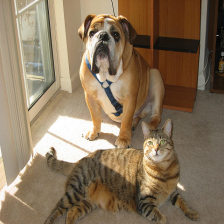

In [191]:
img

In [312]:
np_img = np.array(img)

In [313]:
np_img.shape

(224, 224, 3)

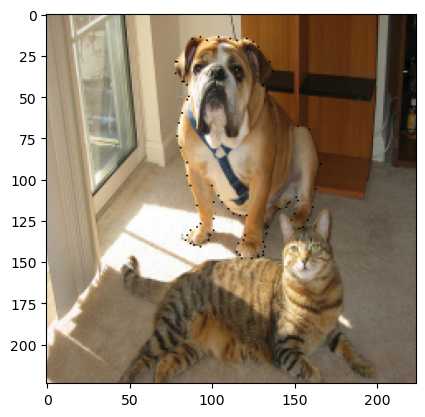

In [194]:
plt.imshow(np_img)

(224, 224)

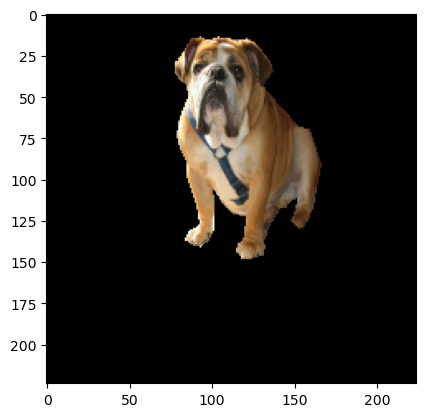

In [314]:
norm_img = np_img
norm_img[120:160, 120:160, :] = np.expand_dims(mask, axis=-1)[120:160, 120:160, :]*norm_img[120:160, 120:160, :]

255


Text(0.5, 0, 'Show 2')

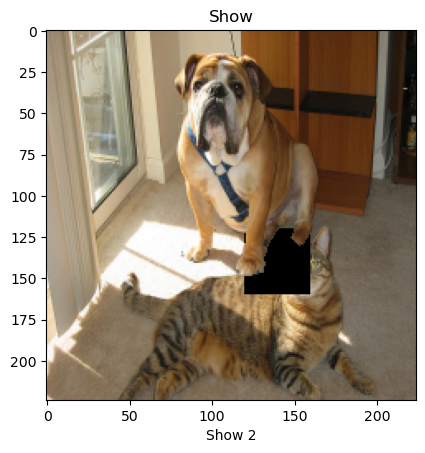

In [329]:
fig, ax = plt.subplots()
plt.imshow(norm_img)
print(norm_img.max())
plt.title("Show")
plt.xlabel("Show 2")

C:\Users\Khisrow\AppData\Local\Temp\ipykernel_74580\825915112.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


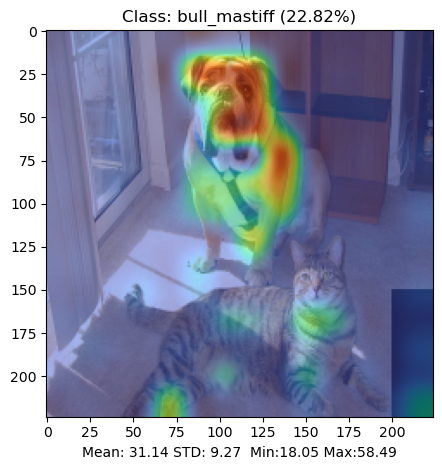

In [25]:
img_path = './examples/input.png'
nrow = 5
ncol = 20

img = Image.open(img_path)
img = img.resize((224, 224))
x_stride = 50
y_stride = 50
occu_size = 50
growth_coef = 15

occlusion = np.zeros((occu_size, occu_size, 3))
np_img = np.array(img)

#fig, ax = plt.subplots(nrow, ncol, figsize=(70, 20))
fig, ax = plt.subplots()
X = np.array([79, 88, 93, 97, 104, 111, 115, 121, 125, 128, 135, 137, 131, 133, 152, 159, 166, 163, 161, 158,
    155, 153, 148, 150, 152, 151, 147, 146, 145, 141, 134, 133, 131, 132, 131, 131, 128, 124, 118,
    117, 115, 116, 119, 120, 121, 117, 113, 110, 106, 104, 100, 101, 101, 101, 99, 98, 93, 89, 87,
    84, 85, 87, 91, 93, 91, 87, 85, 85, 81, 79, 80, 82, 85, 86, 85, 83, 82, 78, 78])
Y = np.array([29, 15, 14, 16, 14, 15, 16, 15, 17, 20, 29, 35, 43, 47, 68, 70, 91, 106, 117, 125, 129, 130, 125,
    121, 113, 111, 114, 115, 117, 118, 129, 133, 138, 141, 144, 146, 147, 148, 148, 146, 144, 139, 137,
    134, 122, 122, 121, 118, 114, 110, 104, 114, 124, 131, 134, 137, 141, 140, 139, 137, 134, 131, 129,
    127, 116, 104, 98, 90, 81, 74, 66, 60, 52, 50, 43, 41, 41, 36, 29])

mask = np.zeros_like(np_img[:,:,0])
polygon_coord = list(zip(X, Y))
mask_img = Image.fromarray(mask)
draw = ImageDraw.Draw(mask_img)
draw.polygon(polygon_coord, fill=1)
mask = np.array(mask_img)
img_mask = np.expand_dims(mask, axis=-1)
probs_list = np.array([])

frames = []

for row in range(nrow):
    x_pos = 0
    y_pos = 0
    x_end = occu_size
    y_end = occu_size
    
    for col in range(ncol):
        tmp_img = np.copy(np_img)
        tmp_img[y_pos:y_end, x_pos:x_end, :] = img_mask[y_pos:y_end, x_pos:x_end, :]*tmp_img[y_pos:y_end, x_pos:x_end, :]

        # NOTE(Abid): Model output and introspection
        input_tensor = transform(Image.fromarray(tmp_img)).unsqueeze(0)
        discard_ratio = 0.9
        logits = model(input_tensor)
        category_index = torch.argmax(logits).item()
        probs = torch.nn.functional.softmax(logits)
        prob = probs[0, category_index]
      
        grad_rollout_call = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout_call(input_tensor, category_index)
        
        heatmap = Image.fromarray(mask)
        heatmap = np.array(heatmap.resize((tmp_img.shape[0], tmp_img.shape[1])))
#         ax[row, col].imshow(tmp_img)
#         heatmap = (heatmap / np.max(heatmap)) * 255.0
#         ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
#                   alpha=0.5)
#         ax[row, col].set_title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")

        plt.imshow(tmp_img)
        heatmap = (heatmap / np.max(heatmap)) * 255.0
        plt.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
                  alpha=0.5)
        probs_list = np.append(probs_list, prob.detach().numpy()*100)
        plt.title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")
        plt.xlabel(f"Mean: {np.mean(probs_list):.2f} STD: {np.std(probs_list):.2f}  Min:{np.min(probs_list):.2f} Max:{np.max(probs_list):.2f}")
        
        # Capture the current figure as an image
        fig = plt.gcf()
        fig.canvas.draw()

        # Convert the figure to an image array
        image_array = np.array(fig.canvas.renderer.buffer_rgba())

        # Convert the image array to PIL Image
        image = Image.fromarray(image_array)

        # Append the image to the list of frames
        frames.append(image)
        
        # NOTE(Abid): Stride logic
        x_pos += x_stride
        x_end = x_pos+occu_size
        if x_pos > tmp_img.shape[0]:
            x_pos = 0
            x_end = x_pos+occu_size
            y_pos += y_stride
            y_end = y_pos+occu_size
        
        elif x_end > tmp_img.shape[0]:
            x_end = tmp_img.shape[0]
            
        if y_pos > tmp_img.shape[1]:
            break
        elif y_end > tmp_img.shape[1]:
            y_end = tmp_img.shape[1]
    occu_size += growth_coef
    
plt.tight_layout()
plt.show()
# fig.savefig('occlusion_masked.png')
imageio.mimsave("occlusion_masked_gif_7fps.gif", frames, fps=7)

C:\Users\Khisrow\AppData\Local\Temp\ipykernel_74580\1682674509.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


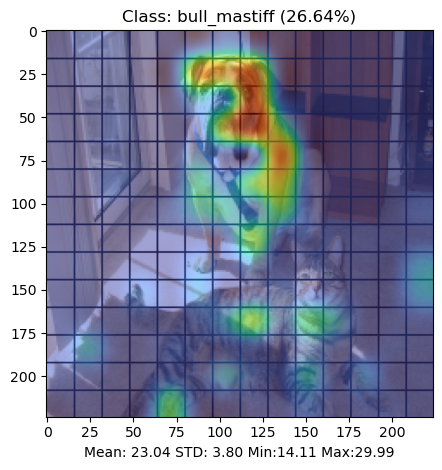

In [26]:
img_path = './examples/input.png'
nrow = 3
ncol = 20

img = Image.open(img_path)
img = img.resize((224, 224))
x_stride = 16*2
y_stride = 16*2
occu_size = 16*4

np_img = np.array(img)


# fig, ax = plt.subplots(nrow, ncol, figsize=(70, 10))
fig, ax = plt.subplots()

finish = False
y_pos = 0

frames = []
probs_list = np.array([])

y_pos = 0
y_end = occu_size
for row in range(nrow):
    x_pos = 0
    x_end = occu_size
    for col in range(ncol):
        tmp_img = np.copy(np_img)
        tmp_img[y_pos:y_end, x_pos:x_end, :] = img_mask[y_pos:y_end, x_pos:x_end, :]*tmp_img[y_pos:y_end, x_pos:x_end, :]
        # NOTE(Abid): Model output and introspection
        input_tensor = transform(Image.fromarray(tmp_img)).unsqueeze(0)
        discard_ratio = 0.9
        logits = model(input_tensor)
        category_index = torch.argmax(logits).item()
        probs = torch.nn.functional.softmax(logits)
        prob = probs[0, category_index]
      
        grad_rollout_call = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout_call(input_tensor, category_index)
        
        for x in range(steps-1):
            pos = (x+1)*patch_size
            tmp_img[:, pos:pos+1, :] = 0
            tmp_img[pos:pos+1, :, :] = 0
            
        heatmap = Image.fromarray(mask)
        heatmap = np.array(heatmap.resize((tmp_img.shape[0], tmp_img.shape[1])))
        # ax[row, col].imshow(tmp_img)
        # heatmap = (heatmap / np.max(heatmap)) * 255.0
        # ax[row, col].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
        #           alpha=0.5)
        # ax[row, col].set_title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")
        
        plt.imshow(tmp_img)
        heatmap = (heatmap / np.max(heatmap)) * 255.0
        plt.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
                  alpha=0.5)
        probs_list = np.append(probs_list, prob.detach().numpy()*100)
        plt.title(f"Class: {classes[category_index]} ({prob*100:.2f}%)")
        plt.xlabel(f"Mean: {np.mean(probs_list):.2f} STD: {np.std(probs_list):.2f} Min:{np.min(probs_list):.2f} Max:{np.max(probs_list):.2f}")
        
        # Capture the current figure as an image
        fig = plt.gcf()
        fig.canvas.draw()

        # Convert the figure to an image array
        image_array = np.array(fig.canvas.renderer.buffer_rgba())

        # Convert the image array to PIL Image
        image = Image.fromarray(image_array)

        # Append the image to the list of frames
        frames.append(image)
        
        # NOTE(Abid): Stride logic
        x_pos += x_stride
        x_end = x_pos+occu_size
        if x_pos > tmp_img.shape[0]:
            x_pos = 0
            x_end = x_pos+occu_size
            y_pos += y_stride
            y_end = y_pos+occu_size
        
        elif x_end > tmp_img.shape[0]:
            x_end = tmp_img.shape[0]
            
        if y_pos > tmp_img.shape[1]:
            finish = True
            break
        elif y_end > tmp_img.shape[1]:
            y_end = tmp_img.shape[1]
    # occu_size += 16
    if finish == True: break
    y_pos += y_stride
    y_end = y_pos+occu_size
    
plt.tight_layout()
plt.show()
imageio.mimsave("occlusion_patch_grid4x_masked_gif_7fps.gif", frames, fps=7)

C:\Users\Khisrow\AppData\Local\Temp\ipykernel_106520\1705632093.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(output)


382
382
382


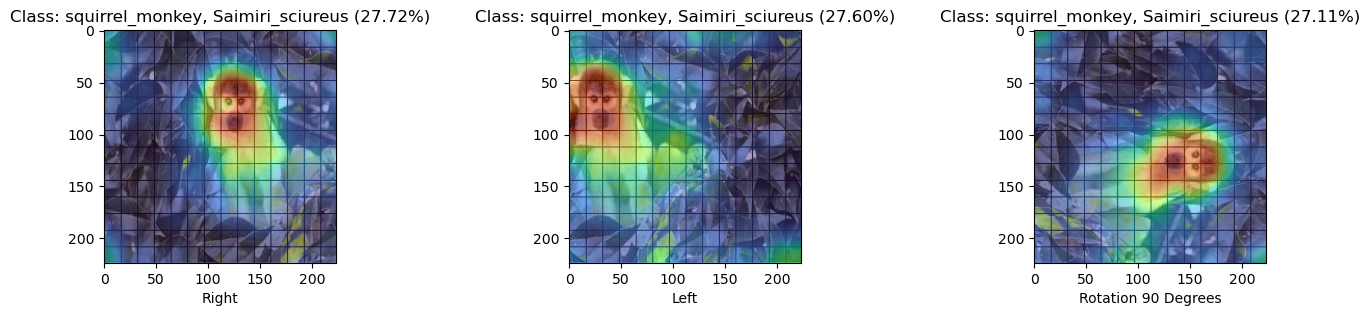

In [65]:
img_right = Image.open('./examples_2/input_2_left.png').convert('RGB')
img_left = Image.open('./examples_2/input_2_right.png').convert('RGB')
img_rot = Image.open('./examples_2/input_2_rotation.png').convert('RGB')
patch_size = 16

fig, ax = plt.subplots(1, 3, figsize=(15, 60))
fig.subplots_adjust(wspace=1)
for idx, (img, orien) in enumerate(zip([img_left, img_right, img_rot], ['Right', 'Left', 'Rotation 90 Degrees'])):
    input_tensor = transform(img).unsqueeze(0)
    steps = int(224/patch_size)

    if use_cuda:
        input_tensor = input_tensor.cuda()

    category_index = None
    head_fusion = 'max'
    discard_ratio = 0.9
    attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
            discard_ratio=discard_ratio)
    mask, output = attention_rollout(input_tensor)

    probs = torch.nn.functional.softmax(output)
    cat_idx = torch.argmax(probs).item()
    print(cat_idx)

    np_img = np.array(img)
    for x in range(steps-1):
        pos = (x+1)*patch_size
        np_img[:, pos:pos+1, :] = 0
        np_img[pos:pos+1, :, :] = 0

    heatmap = Image.fromarray(mask)
    heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
    ax[idx].imshow(np_img)
    heatmap = (heatmap / np.max(heatmap)) * 255.0
    ax[idx].imshow(heatmap, cmap='turbo', # seismic, hot, Reds
              alpha=0.5)
    ax[idx].set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")
    ax[idx].set_xlabel(f"{orien}")
plt.show()

### Stuff to talk about in the presentation:
- The accuracy of the model increases once the extraneous attentional parts are removed from the input itself
- However, as the size of the occlusion blocks increase, the accuracy starts to decrease again. We believe it has to do with 2 main characteristics of the model
    - The model has been trained using knowledge distillation, with ResNet as a teacher. You can think of the deit model a conv model that has a stride as large as its kernel size. Therefore the model has has local connectivity within its surrounding. We can observe the conv properties of the model by looking at the fact that the model has learned to respect translation equivariance. (figure above)
    - A more important reason for this, we believe, is that that since the model has a stride larger than 1 (in fact the stride is the size of the kernel itself) the patches are tainted whenever they are they set of zero halfway through (unaligned) and since in stride close to 1 values tend to blur into one another, a place that has been set to zero does not have a big of an impact as it does here in case of large strides. Put it simply, in small strides we take a lot of samples of one spot and the model gets a color gradient of values at the patch and it gets smoothed-out.
- This leads us to the next observation that outside target-object occlusion accross the patch boundaries (aligned occlusions) seems to have negligible effect on the accuracy of the model itself. We believe the aligned occlusion to be the true indicator of the importance of patches and attention for a specific classification, since it does not pollute the other patches of the network and removes the influence of a certain region of the input.
- The discrepency can been seen in the Min/Max and Std of the the accuracies of the model.

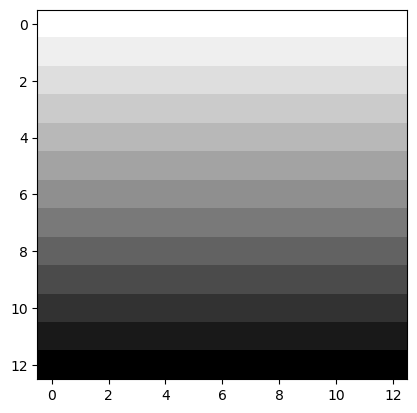

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d 
image = np.zeros((100, 100), dtype=np.float32)

# Calculate the midpoint of the height
midpoint = int(image.shape[0] // 1.5)

# Set the top half (channels 0 to 2) to black (all zeros)
image[:midpoint, :] = 0.0

# Set the bottom half (channels 0 to 2) to white (all ones)
image[midpoint:, :] = 1.0
kernel = np.ones((10, 10), dtype=np.float32)
stride = 4

#result = convolve2d(image, kernel, mode='valid')

# print(result)

#result2 = convolve2d(result, kernel, mode='valid')
result3 = convolve2d(result2, kernel, mode='valid')
plt.imshow(image, cmap="binary")
plt.imshow(result, cmap="binary")
plt.imshow(result2, cmap="binary")
plt.imshow(result3, cmap="binary")


In [7]:
torch.__version__

'1.13.1'

In [8]:
import torchvision

In [9]:
torchvision.__version__

'0.14.1'

In [11]:
import torchaudio
torchaudio.__version__

E:\vendors\anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


'0.13.1'

In [12]:
torch.version.cuda

'11.7'